# Information Sampling Task

<div>
    <p style="float: left;"><img src="images/card_game.png" alt="Drawing" style="width: 200px; border-right:10px solid white"/> 
    <p>During the information sampling task, participants have to chose between decks of cards.  They can invest points to turn cards up (sample information) before making their choice.</p><p>Crucially, they have to either chose the smallest or biggest option (approach manipulation).  In Hunt's original task there were three crossed conditions (single card, multiple, addition), but in our version only the addition condition is used. </p><p>Hunt et al. (2016) mentions there biases that can be calculated based on this task: "positive evidence approach", "sampling the favourite", and "rejecting unsampled options".  According to Hunt et al. all these biases are related to Pavlovian approach-avoidance.</p>
</div>


In [ ]:
%run ../src/wp1/init.ipynb
%reload_ext rpy2.ipython
from wp1 import stats, data_provider as dp # This is the local wp1 package in analysis/src

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%capture
%%R
library(lme4)
library(lmerTest)
library(ggeffects)
control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e5))  #mixed logistic regression

In [ ]:
# We're running these analyses on the baseline GBE data (data from first two GBE sessions; when performed on same day).
bs = dp.get_gbe_baseline_data() # ToDo: add sample variable ("initial" vs. "replication")
bs = bs[bs.initial] # For now, we only look at the initial dataset
print("Risk taking data from %s sessions is missing."%bs['CardGame'].isnull().sum())
bs = bs[bs['CardGame'].isnull()==False]
print("We have data from %s participants and %s sessions."%(len(bs.participant.unique()), len(bs)))

Risk taking data from 22 sessions is missing.
We have data from 289 participants and 531 sessions.


In [ ]:
def decode_cg_strings(df):
    column = "CardGame"
    '''Turning df into trial-level df based on GBE strings.
    '''
    gbe_data = pd.concat(df.set_index(['participant','baseline_session'])[column].apply(decode_cg_string).values, keys = df.index)
    gbe_data.index.rename('trial_index',level = 1, inplace = True)
    df = pd.merge(left=df, right=gbe_data.reset_index(level=1), left_index = True, right_index = True).reset_index()
    df['trial_index'] = df.trial_index + 1 # Making the trial index one-based
    return df

def decode_cg_string(s):
    """This helper function turns gbe output strings into dataframes"""
    def replace(g):
        return g.group(0).replace(',', '|')

    s = re.sub(r'\[.*?\]', replace, s)
    columns, df = s.replace('","',';').replace('"','').split('\n')
    df = pd.DataFrame([column.split(',') for column in df.split(';')][:-1]).transpose().ffill().iloc[:-1]
    df.columns = [c.replace('tr_','') for c in columns.split(',')[:-1]]
    # Changing variable types
    if 'appversion' in df.columns:
        df['timestarted'] = pd.to_datetime(df.timestarted.str[1:-5])
        df['timesubmitted'] = pd.to_datetime(df.timesubmitted.str[1:-5])
        if 'cardlist' in df.columns:
            float_columns = ['decisiontime','guesstime','secondcard','success','trialtype']
            df[float_columns] = df[float_columns].astype(float)
        else:
            df[df.columns[5:]] = df[df.columns[5:]].astype(float)
    
    else:
        df[['appversion','timestarted','timesubmitted','score']] = pd.Series([np.nan,np.nan,np.nan,np.nan])
        df = df.astype(float)
    df['first_card'] = df.cardlist.str.replace('[','').str.split('|').apply(lambda x: x[0]).astype(int).apply(lambda x: (x+1)%10)
    df['information_value'] = abs(df.first_card - 5.5)
    back_to_list = lambda x: x.strip('[]').replace('|',',').split(',')
    df['cardlist'] = df.cardlist.apply(back_to_list)
    df['movelist'] = df.movelist.apply(back_to_list)
    df['turntime'] = df.turntime.apply(back_to_list)
    df['deck_id'] = df.cardlist.apply(lambda x: ''.join([str((int(c)-1)%10) for c in x]))
    df['turns'] = df.turntime.apply(lambda x: len(x))

    return df
    
    
def get_cg_data(df):
    df = decode_cg_strings(df)
    df['trial_number'] = df.groupby(['participant','baseline_session']).cumcount()+1
    df['is_even'] = (df.trial_index+1)%2
    with open('opt_string.txt','r') as f: # This file is produced based on infotask_dyprog_AA_trials.m from Hunt
        optimal_turns = f.read()
    # Getting optimal turns from Hunt's model
    ot = optimal_turns.split('\n')
    ot = [x.split(':') for x in ot][:-1]
    ot = [[list(eval(x[0])),int(x[1])] for x in ot]
    ot = pd.DataFrame(ot)
    ot.columns = ['card_values','optimal_turns']
    ot['deck_id'] = ot.card_values.apply(lambda x: ''.join([str(y-1) for y in x]))
    df = df.merge(ot[['deck_id','optimal_turns']], on='deck_id',validate='many_to_one').sort_values(by=['participant','baseline_session']).reset_index(drop = True)
    df['oversampling'] = df.turns - df.optimal_turns
    cg_vars = ["timestarted", "timesubmitted", "guesstime", "secondcard", "success", "is_even", "trialtype", "cardlist" ,"movelist", "turntime", "deck_id",'turns','optimal_turns','oversampling']
    df = df[['mov_index','gbe_index','gbe_baseline_index','initial','trial_index','participant','baseline_session']+cg_vars]
    return df

df = get_cg_data(bs)

is_multiplicative = (df.set_index('participant')['trialtype']<2).reset_index().groupby('participant').max()
wrong_game_pps = list(is_multiplicative[is_multiplicative.trialtype].index)
print("%d participants used the wrong version of the game."%len(wrong_game_pps))
df = df[df.participant.isin(wrong_game_pps)==False]

2 participants used the wrong version of the game.


In [ ]:
bs = bs[bs.participant.isin(wrong_game_pps)==False]

In [ ]:
#dp = reload(dp)
#df = dp.get_rtt_data(bs)
#df = df[df.initial]

# Mean method
Here we simply calculate the mean oversampling, separately for each participant and session.

Example data for the win condition in one participant-session:

In [ ]:
example = df.query("participant=='b002' and baseline_session=='Session 1'")[['participant','baseline_session','turns','optimal_turns','oversampling']]
display(example.reset_index(drop=True))
print("The participants' average oversampling in this session is %.2f"%(example.oversampling.mean()))

,participant,baseline_session,turns,optimal_turns,oversampling
0,b002,Session 1,2,1,1
1,b002,Session 1,3,4,-1
2,b002,Session 1,2,4,-2
3,b002,Session 1,2,1,1
4,b002,Session 1,2,2,0
5,b002,Session 1,2,1,1
6,b002,Session 1,2,3,-1
7,b002,Session 1,3,1,2
8,b002,Session 1,3,1,2
9,b002,Session 1,2,2,0


The participants' average oversampling in this session is 0.05


In [ ]:
def get_average_oversampling(df):
    return df.groupby(['participant','baseline_session']).agg({'oversampling':'mean','gbe_baseline_index':'first'}).set_index('gbe_baseline_index')

bs['mean_oversampling'] = get_average_oversampling(df)
bs['mean_oversampling_even'] = get_average_oversampling(df.query('is_even==True'))
bs['mean_oversampling_uneven'] = get_average_oversampling(df.query('is_even==False'))
    

<AxesSubplot:>

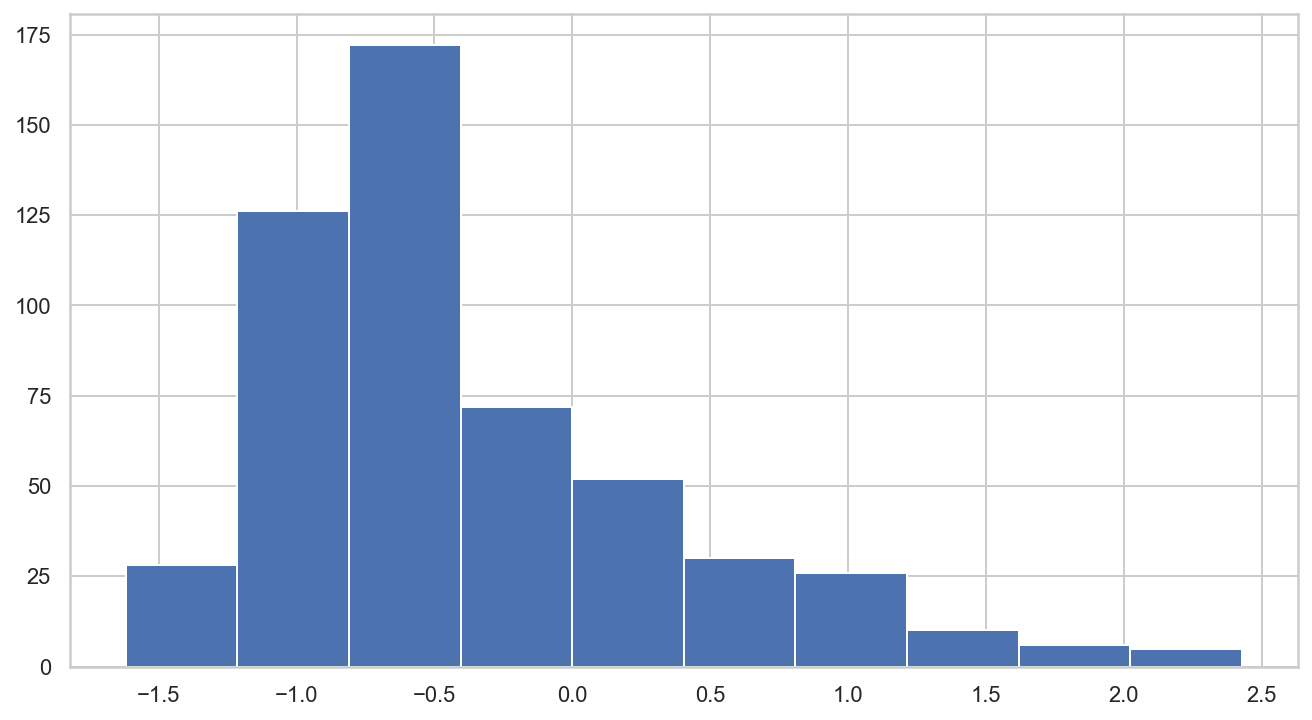

In [ ]:
bs.mean_oversampling.hist()

## Internal consistency (split-half reliability)

### Oversampling

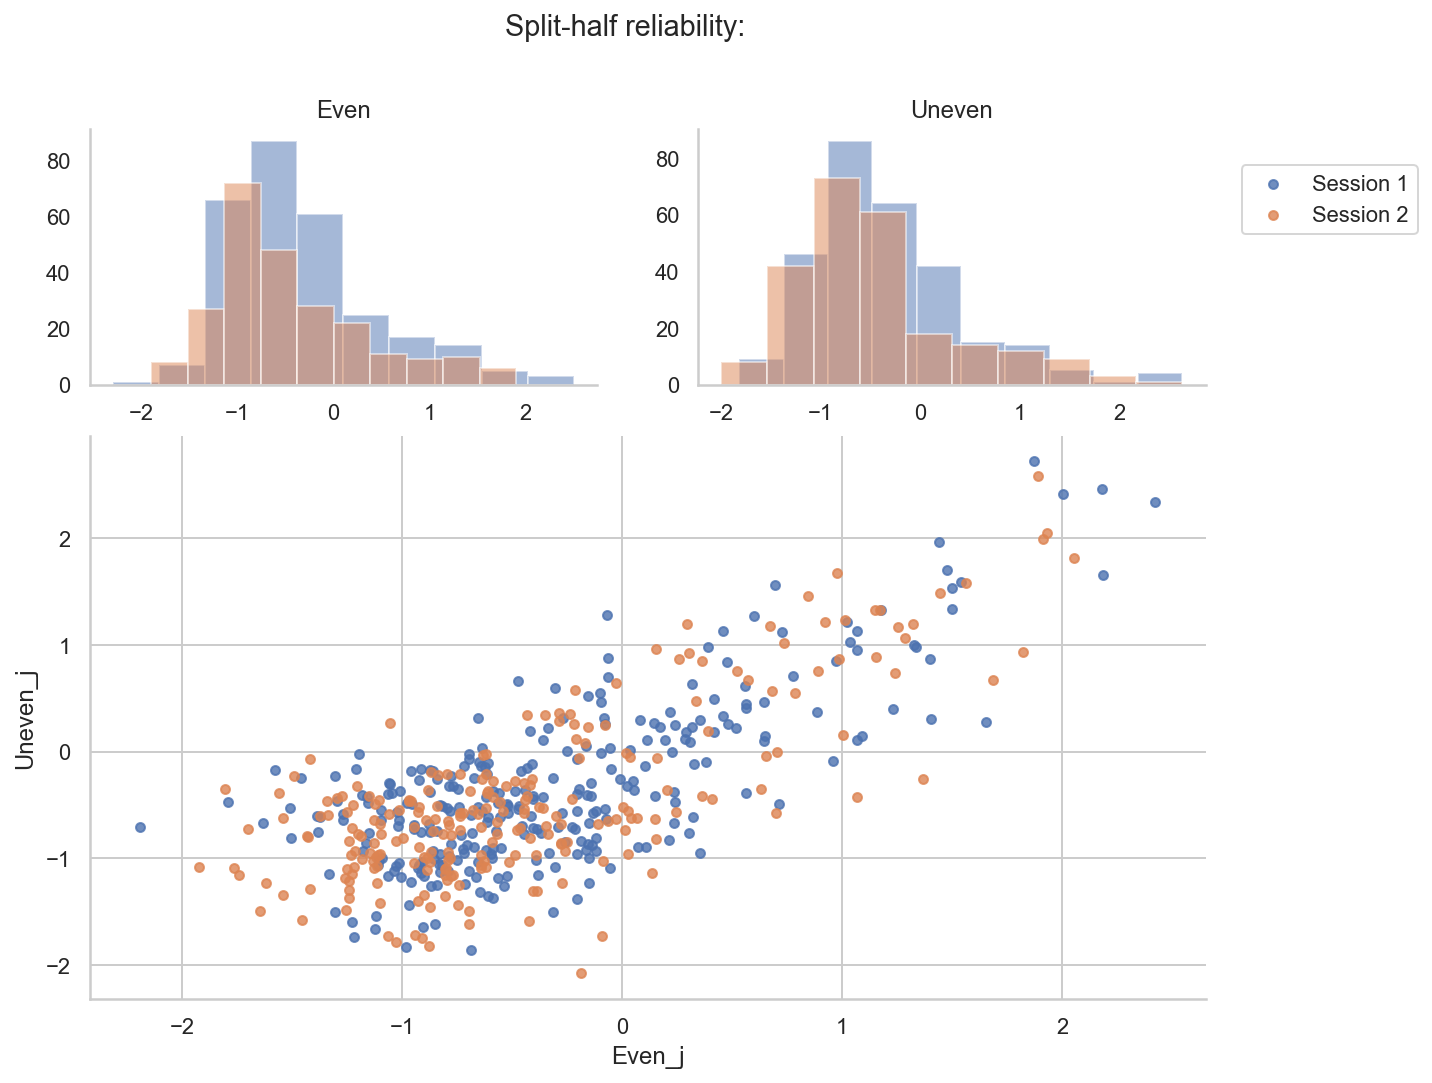

In [ ]:
os_mean = stats.analyze_split_half(bs, "mean_oversampling_even", "mean_oversampling_uneven", add_jitter = True)

## Test-retest reliability

### Percentage gambles win

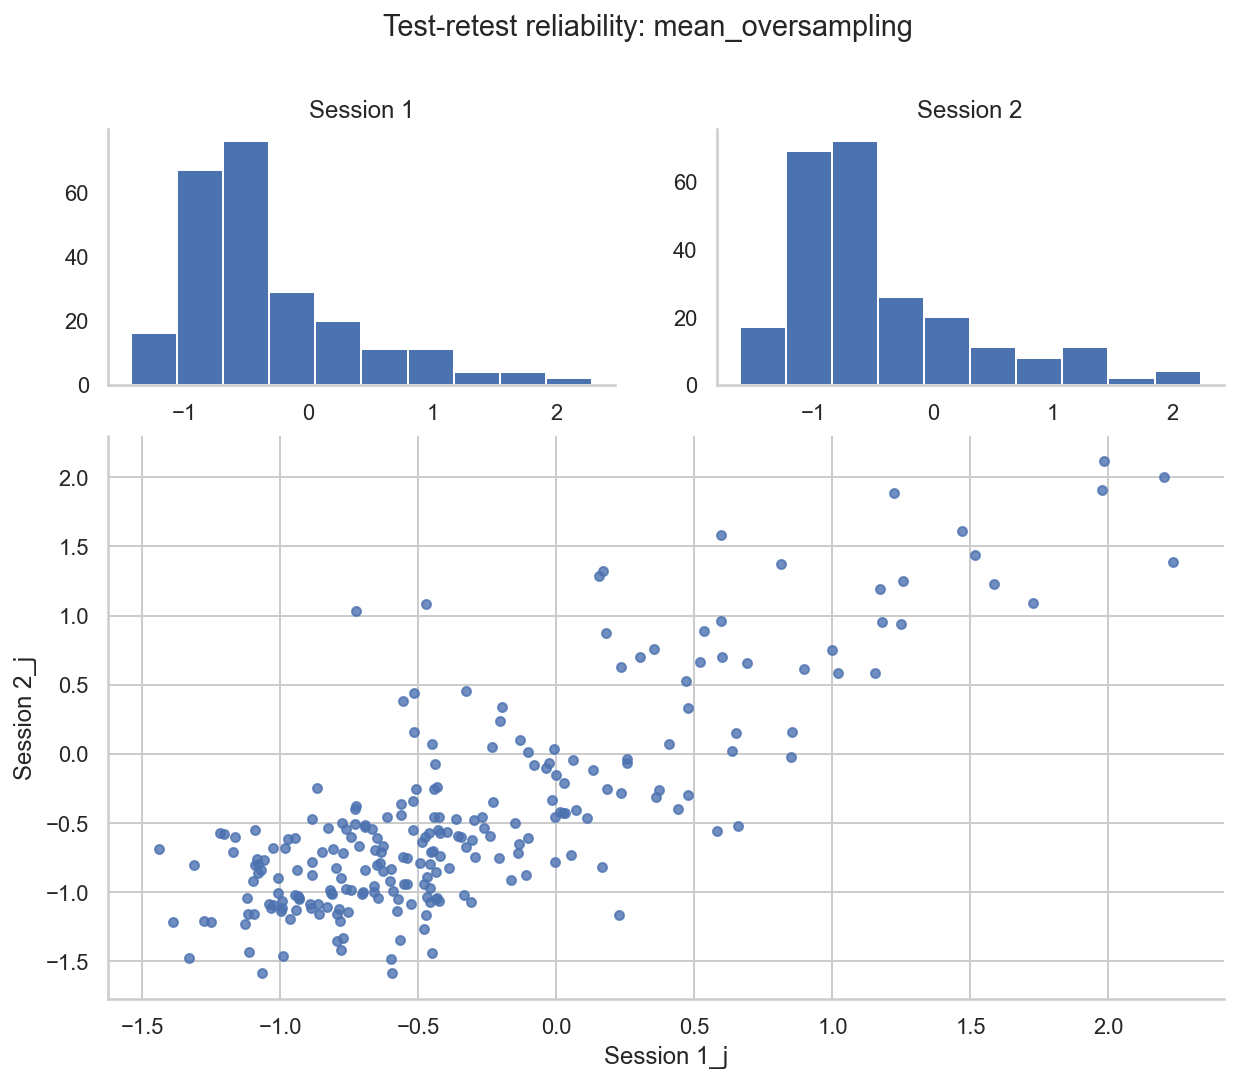

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
0,ICC1,0.860,25.625,239.0,720.0,0.0,0.838,0.881,".86 (.84, .88)"
1,ICC2,0.861,27.163,239.0,717.0,0.0,0.836,0.883,".86 (.84, .88)"
2,ICC3,0.867,27.163,239.0,717.0,0.0,0.846,0.887,".87 (.85, .89)"
3,ICC1k,0.961,25.625,239.0,720.0,0.0,0.954,0.967,".96 (.95, .97)"
4,ICC2k,0.961,27.163,239.0,717.0,0.0,0.953,0.968,".96 (.95, .97)"
5,ICC3k,0.963,27.163,239.0,717.0,0.0,0.956,0.969,".96 (.96, .97)"


,type,variance,Percent
0,Participant,0.457,0.861
1,Session,0.004,0.008
2,Residual,0.070,0.132
3,Total,0.531,1.000


In [ ]:
stats = reload(stats)
iccs_mean = stats.analyze_reliability(bs, "mean_oversampling", add_jitter = True)

The task's reliability is moderate to good (based on confidence intervals and according to criteria by Koo and Li, 2016).

# Trial level analysis (sessions modeled separately)
ToDo: This should be equivalent to mean method.  Perhaps try to find out why this is not always the case, here.

In [ ]:
example = df.query("baseline_session=='Session 1'")[['participant','baseline_session','turns','optimal_turns','oversampling']]
display(example)

,participant,baseline_session,turns,optimal_turns,oversampling
42,b002,Session 1,2,1,1
43,b002,Session 1,3,4,-1
44,b002,Session 1,2,4,-2
45,b002,Session 1,2,1,1
46,b002,Session 1,2,2,0
...,...,...,...,...,...
11125,m205,Session 1,2,1,1
11126,m205,Session 1,2,4,-2
11127,m205,Session 1,3,1,2
11128,m205,Session 1,2,1,1


Predicting `oversampling` with `1 + (1 | participant)` (random intercepts for participants) separately for each session.

## Advantages over mean method
- Data from other participants is included in the model.  
- Trial-level analysis allows to introduce extra explanatory variables (not done yet).

In [ ]:
def get_oversampling_trial_sep(df):
    s1 = df.query('baseline_session == "Session 1"')
    s2 = df.query('baseline_session == "Session 2"')
    %R m1 = lmer(oversampling ~ 1 + (1 | participant), data=s1,  na.action = na.exclude) -i s1
    %R m2 = lmer(oversampling ~ 1 + (1 | participant), data=s2,  na.action = na.exclude) -i s2
    %R p1 <- ggpredict(m1, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p1
    %R p2 <- ggpredict(m2, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p2
    p1.columns = ['participant','predicted','baseline_session']
    p2.columns = ['participant','predicted','baseline_session']
    p1['baseline_session'] = 'Session 1'
    p2['baseline_session'] = 'Session 2'
    predicted = pd.concat([p1,p2], ignore_index = True)
    # This line is ugly (all it does is bring the data back to the gbe_baseline_index)
    predicted = pd.merge(predicted, df.groupby(['participant','baseline_session'])['gbe_baseline_index'].first().reset_index(), on = ['participant','baseline_session'], how='inner', validate='one_to_many').set_index('gbe_baseline_index')['predicted']
    return predicted


# ToDo: Should this be trial_number?
r_data = df[['gbe_baseline_index','participant','baseline_session','trial_index','is_even','oversampling']]
r_data['session'] = r_data.baseline_session.apply(lambda x: int(x.split(' ')[1]))

#for trial_type in ['win','loss','mixed']:
#    type_data = r_data.query('trial_type=="%s"'%trial_type)
bs['oversampling_trial_separate'] = get_oversampling_trial_sep(r_data)
bs['oversampling_trial_separate_even'] = get_oversampling_trial_sep(r_data.query('is_even==True'))
bs['oversampling_trial_separate_uneven'] = get_oversampling_trial_sep(r_data.query('is_even==False'))
#


## Internal consistency (split-half reliability)

### Oversampling

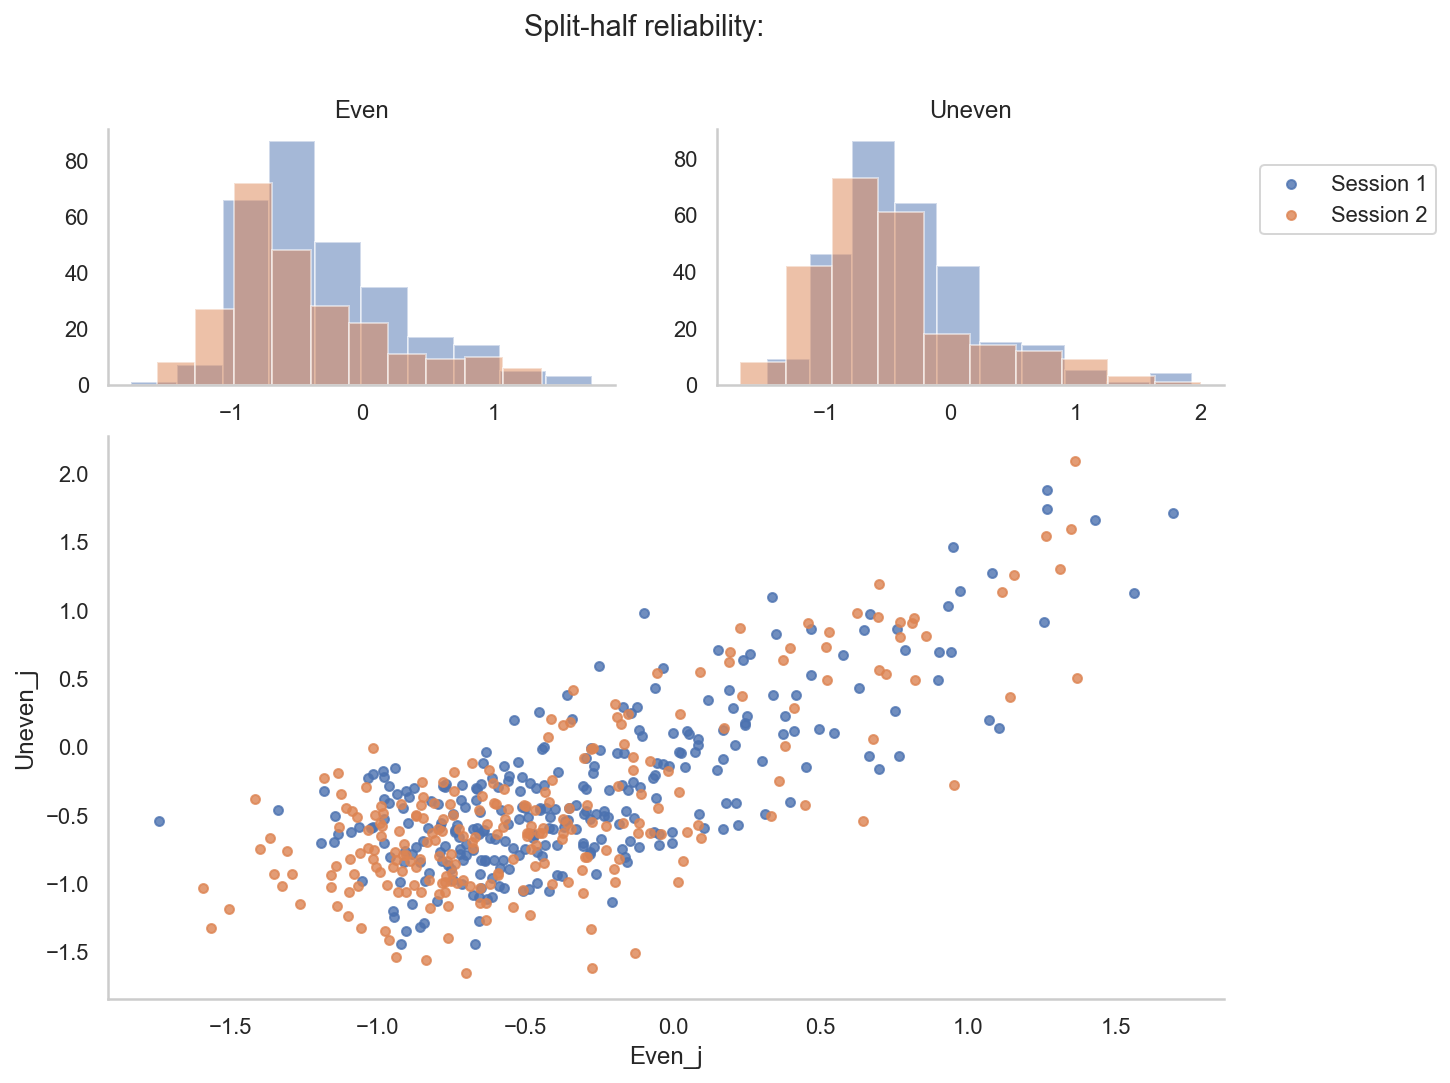

In [ ]:
os_trial_sep = stats.analyze_split_half(bs, "oversampling_trial_separate_even", "oversampling_trial_separate_uneven", add_jitter = True)

## Test-retest reliability

### Percentage gambles win

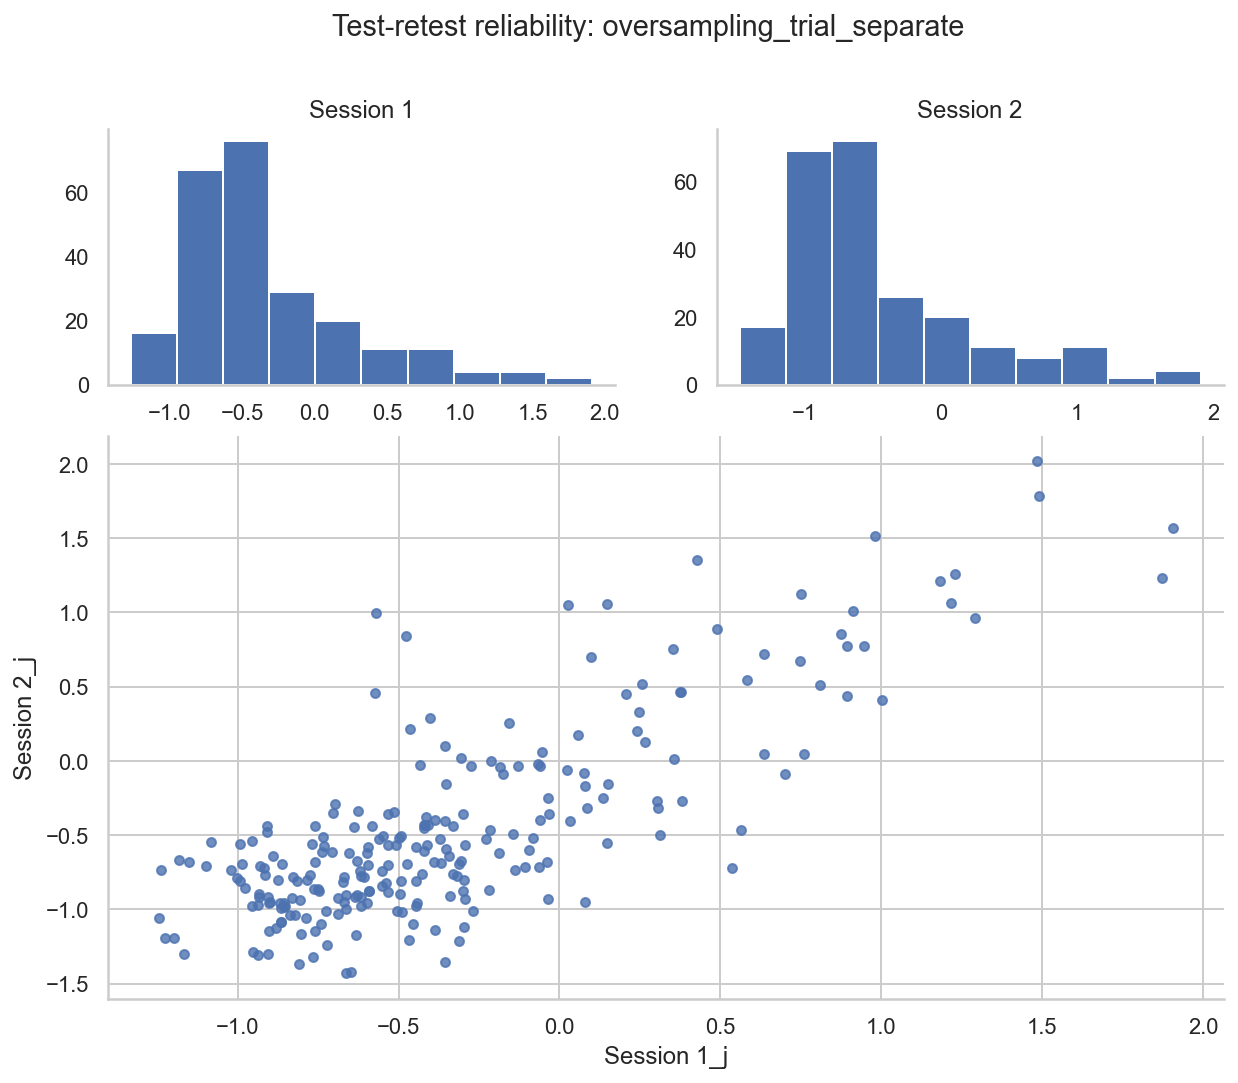

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
0,ICC1,0.854,24.402,239.0,720.0,0.0,0.830,0.876,".85 (.83, .88)"
1,ICC2,0.854,26.308,239.0,717.0,0.0,0.827,0.878,".85 (.83, .88)"
2,ICC3,0.864,26.308,239.0,717.0,0.0,0.841,0.884,".86 (.84, .88)"
3,ICC1k,0.959,24.402,239.0,720.0,0.0,0.951,0.966,".96 (.95, .97)"
4,ICC2k,0.959,26.308,239.0,717.0,0.0,0.950,0.967,".96 (.95, .97)"
5,ICC3k,0.962,26.308,239.0,717.0,0.0,0.955,0.968,".96 (.95, .97)"


,type,variance,Percent
0,Participant,0.342,0.854
1,Session,0.004,0.011
2,Residual,0.054,0.135
3,Total,0.400,1.000


In [ ]:
iccs_trial_sep = stats.analyze_reliability(bs, "oversampling_trial_separate", add_jitter = True)

The task's reliability is moderate to good.

# Trial level analysis (sessions modeled jointly)

In [ ]:
example = df[['participant','baseline_session','oversampling']].iloc[:-155]
display(example)

,participant,baseline_session,oversampling
42,b002,Session 1,1
43,b002,Session 1,-1
44,b002,Session 1,-2
45,b002,Session 1,1
46,b002,Session 1,0
...,...,...,...
10991,m192,Session 1,-1
10992,m192,Session 1,-1
10993,m192,Session 1,0
10994,m192,Session 1,0


Predicting `is_gamble` with `1 + (1 | participant / session)` (sessions nested in participants) with all win-trial data in the model.

## Advantages over mean method
- Data from other participants <i>and sessions</i> is included in the model.  
- Trial-level analysis allows to introduce extra explanatory variables (not done yet).

In [ ]:
def get_oversampling_trial_joint(df):
    %R m = lmer(oversampling ~ 1 + (1 | participant / session), data=df, na.action = na.exclude) -i df -o m
    %R p <- ggpredict(m, terms=c("participant[all]", "session"), type="re",ci.lvl = NA) -o p
    p.columns = ['participant','predicted','baseline_session']
    p.baseline_session.replace({'1':"Session 1",'2':"Session 2"}, inplace = True)
    predicted = pd.merge(p, df.groupby(['participant','baseline_session'])['gbe_baseline_index'].first().reset_index(), on = ['participant','baseline_session'], how='inner', validate='one_to_many').set_index('gbe_baseline_index')['predicted']
    return predicted, m


r_data = df[['gbe_baseline_index','participant','baseline_session','trial_index','is_even','oversampling']]
r_data['session'] = r_data.baseline_session.apply(lambda x: int(x.split(' ')[1]))
models = {}

bs['oversampling_trial_joint'], models['oversampling_trial_joint'] = get_oversampling_trial_joint(r_data)
bs['oversampling_trial_joint_even'], _ = get_oversampling_trial_joint(r_data.query('is_even==True'))
bs['oversampling_trial_joint_uneven'], _ = get_oversampling_trial_joint(r_data.query('is_even==False'))

## Internal consistency (split-half reliability)

### Oversampling

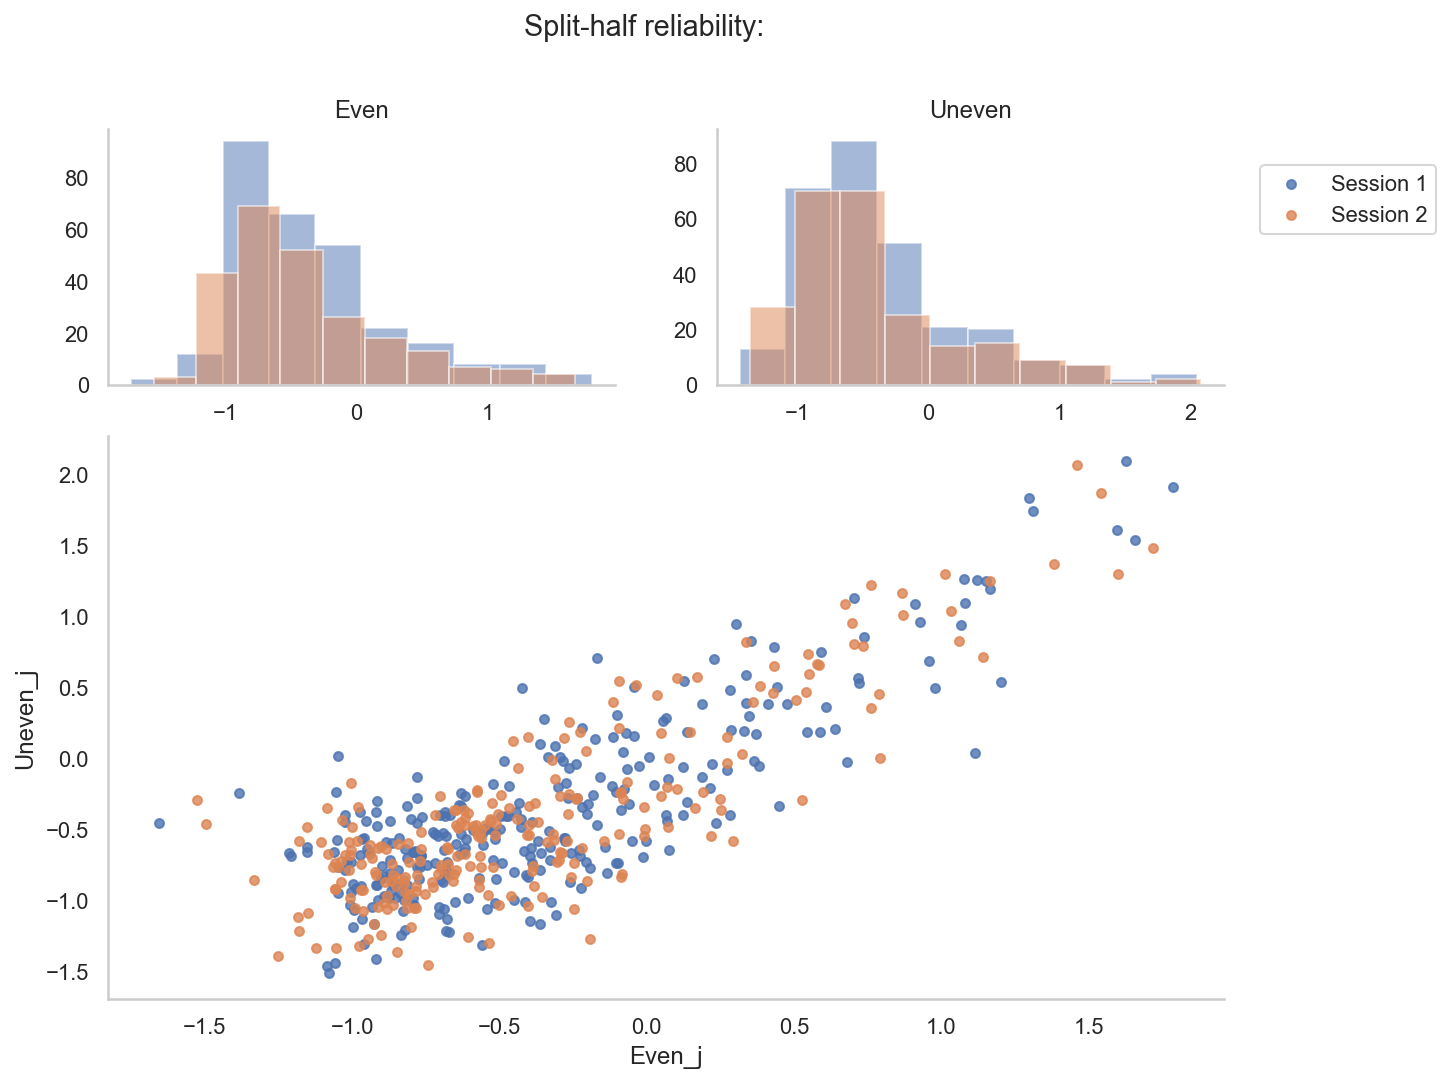

In [ ]:
os_trial_joint = stats.analyze_split_half(bs, "oversampling_trial_joint_even", "oversampling_trial_joint_uneven", add_jitter = True)

## Test-retest reliability

### Percentage gambles win

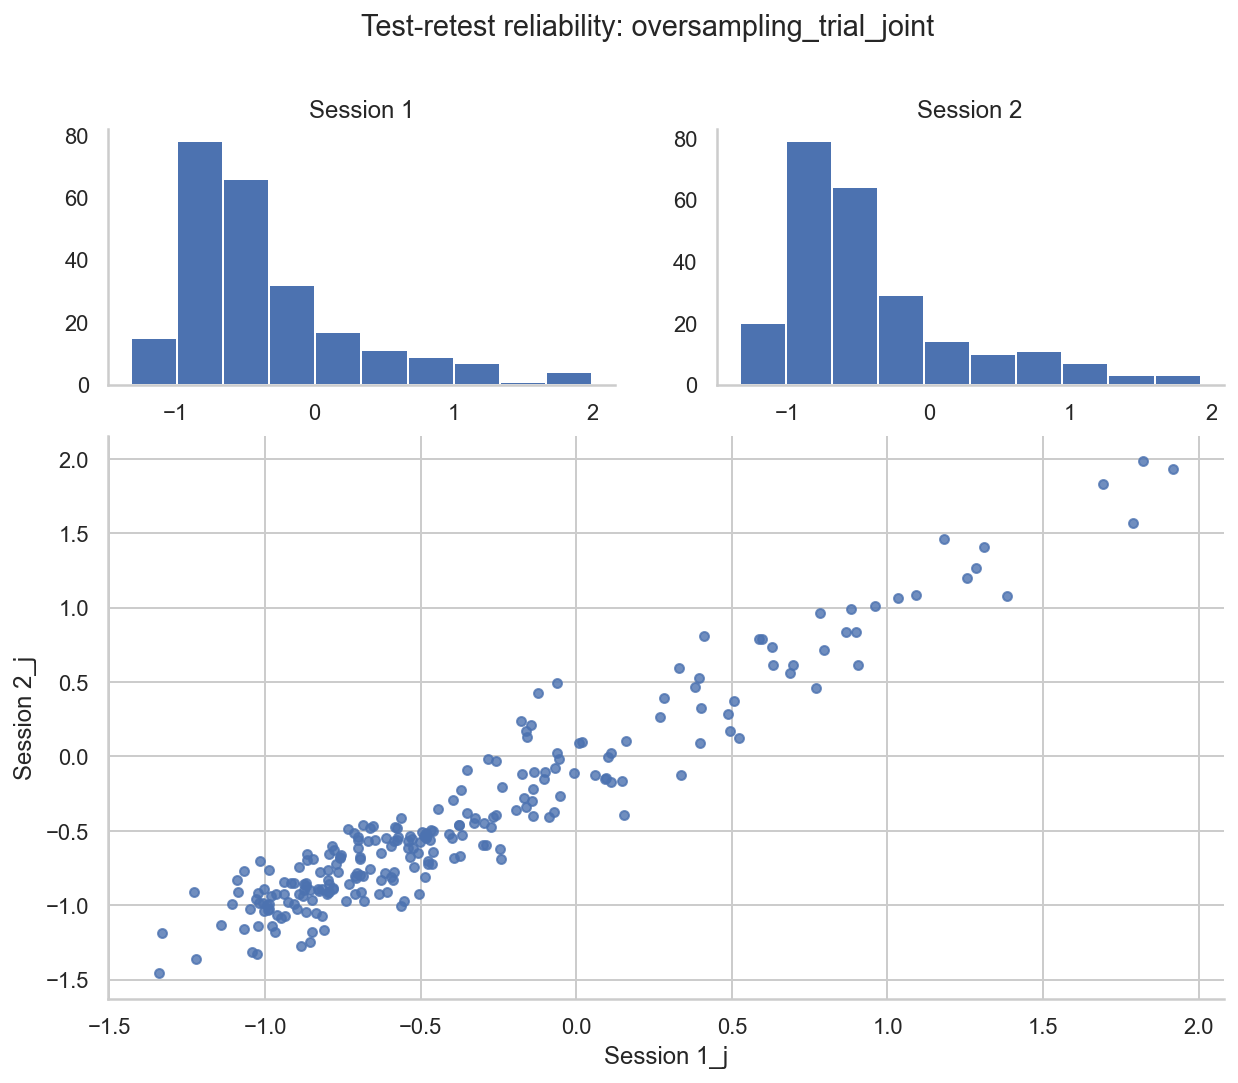

,type,ICC,F,df1,df2,p,lower bound,upper bound,description
0,ICC1,0.973,146.192,239.0,720.0,0.0,0.968,0.977,".97 (.97, .98)"
1,ICC2,0.973,153.760,239.0,717.0,0.0,0.968,0.978,".97 (.97, .98)"
2,ICC3,0.974,153.760,239.0,717.0,0.0,0.970,0.979,".97 (.97, .98)"
3,ICC1k,0.993,146.192,239.0,720.0,0.0,0.992,0.994,".99 (.99, .99)"
4,ICC2k,0.993,153.760,239.0,717.0,0.0,0.992,0.994,".99 (.99, .99)"
5,ICC3k,0.993,153.760,239.0,717.0,0.0,0.992,0.995,".99 (.99, .99)"


,type,variance,Percent
0,Participant,0.404,0.973
1,Session,0.001,0.001
2,Residual,0.011,0.025
3,Total,0.415,1.000


In [ ]:
iccs_trial_joint = stats.analyze_reliability(bs, "oversampling_trial_joint", add_jitter = True)

Reliability is good to excellent.

#### Based on model variances
Question: Why do we call session variance residual variance in this formula?

In [ ]:
def get_model_calculated_icc(m):
    %R require(insight) -i m
    %R var_sess <- get_variance_intercept(m)[1]
    %R var_pp <- get_variance_intercept(m)[2]
    %R icc <- var_pp / (var_pp+(var_sess)) -o icc -o var_sess -o var_pp
    # Note that what get_variance_intercept outputs as session variance, we call residual, here
    variances = pd.DataFrame({"type":["Participant","Session","Residual"],"variance":[var_pp[0],0,var_sess[0]]})
    variances["Percent"] = variances.variance/variances.variance.sum()
    variances = {'iccs':[None, variances]}
    return {'icc':icc[0],'variances':variances}
model_calculated_iccs = {}
model_calculated_iccs['oversampling_trial_joint'] = get_model_calculated_icc(models['oversampling_trial_joint'])
model_calculated_iccs['oversampling_trial_joint']['icc']

R[write to console]: Loading required package: insight



0.9205893162469

In [ ]:
model_calculated_iccs['perc_gamble_trial_joint_mixed'] = get_model_calculated_icc(models['perc_gamble_trial_joint_mixed'])
model_calculated_iccs['perc_gamble_trial_joint_mixed']['icc']

0.7861487175988547

# Comparison of methods

## Internal consistency

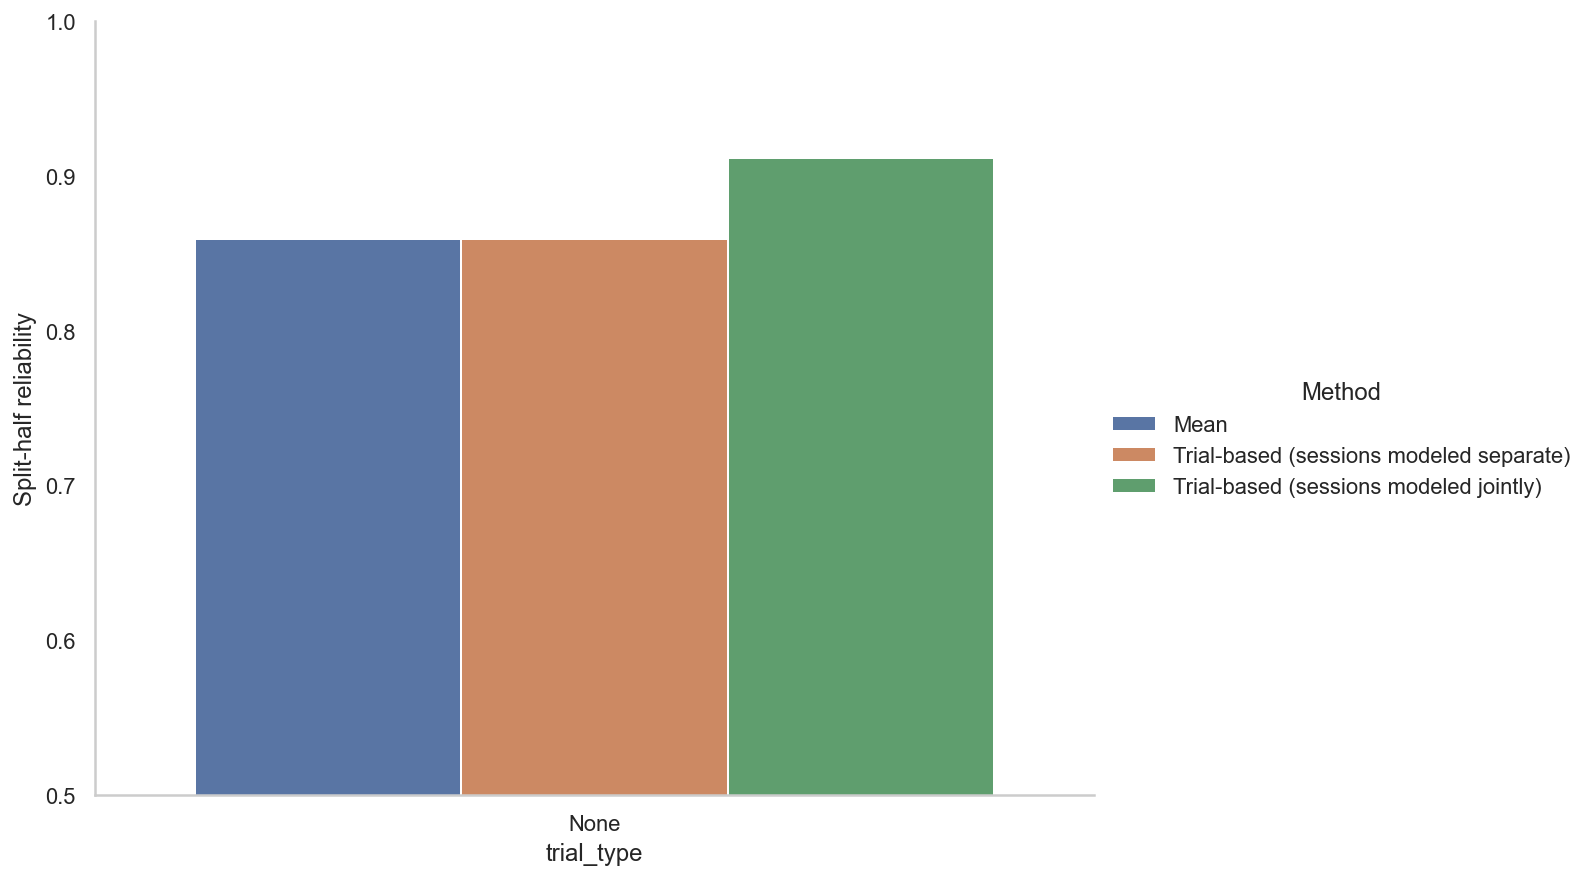

In [ ]:
df = pd.DataFrame({})
df.loc['mean_1','sb'] = os_mean['spearman_browns'][0]
df.loc['mean_2','sb'] = os_mean['spearman_browns'][1]
df.loc['trial_sep_1','sb'] =   os_trial_sep['spearman_browns'][0]
df.loc['trial_sep_2','sb'] =   os_trial_sep['spearman_browns'][1]
df.loc['trial_joint_1','sb'] =   os_trial_joint['spearman_browns'][0]
df.loc['trial_joint_2','sb'] =   os_trial_joint['spearman_browns'][1]


df = df.reset_index()
df.rename(columns = {'index':'category','sb':'Split-half reliability'}, inplace = True)
df['session'] = df.category.apply(lambda x: x.split('_')[-1])
df['trial_type'] = "None"
df['Method'] = df.category.apply(lambda x: '_'.join(x.split('_')[:-1]))
df.Method.replace({'mean':'Mean',
                  'trial_sep':'Trial-based (sessions modeled separate)',
                  'trial_joint':'Trial-based (sessions modeled jointly)'
                  }, inplace = True)


g = sns.catplot(x = "trial_type",       # x variable name
            y = "Split-half reliability",       # y variable name
            hue = "Method",  # group variable name
            data = df,     # dataframe to plot
            kind = "bar",
           ci = None,
            height=6, aspect=1.3)
g.set(ylim=(.5, 1))
ax = g.axes[0][0]
#ax.axhline(.8, color = 'black')

Questions:
- Do the improved split-half reliabilities indicate that the joint method indeed decreases measurement error?

## Test-retest reliability

In [ ]:
model_calculated_iccs['oversampling_trial_joint']['icc']

0.9205893162469

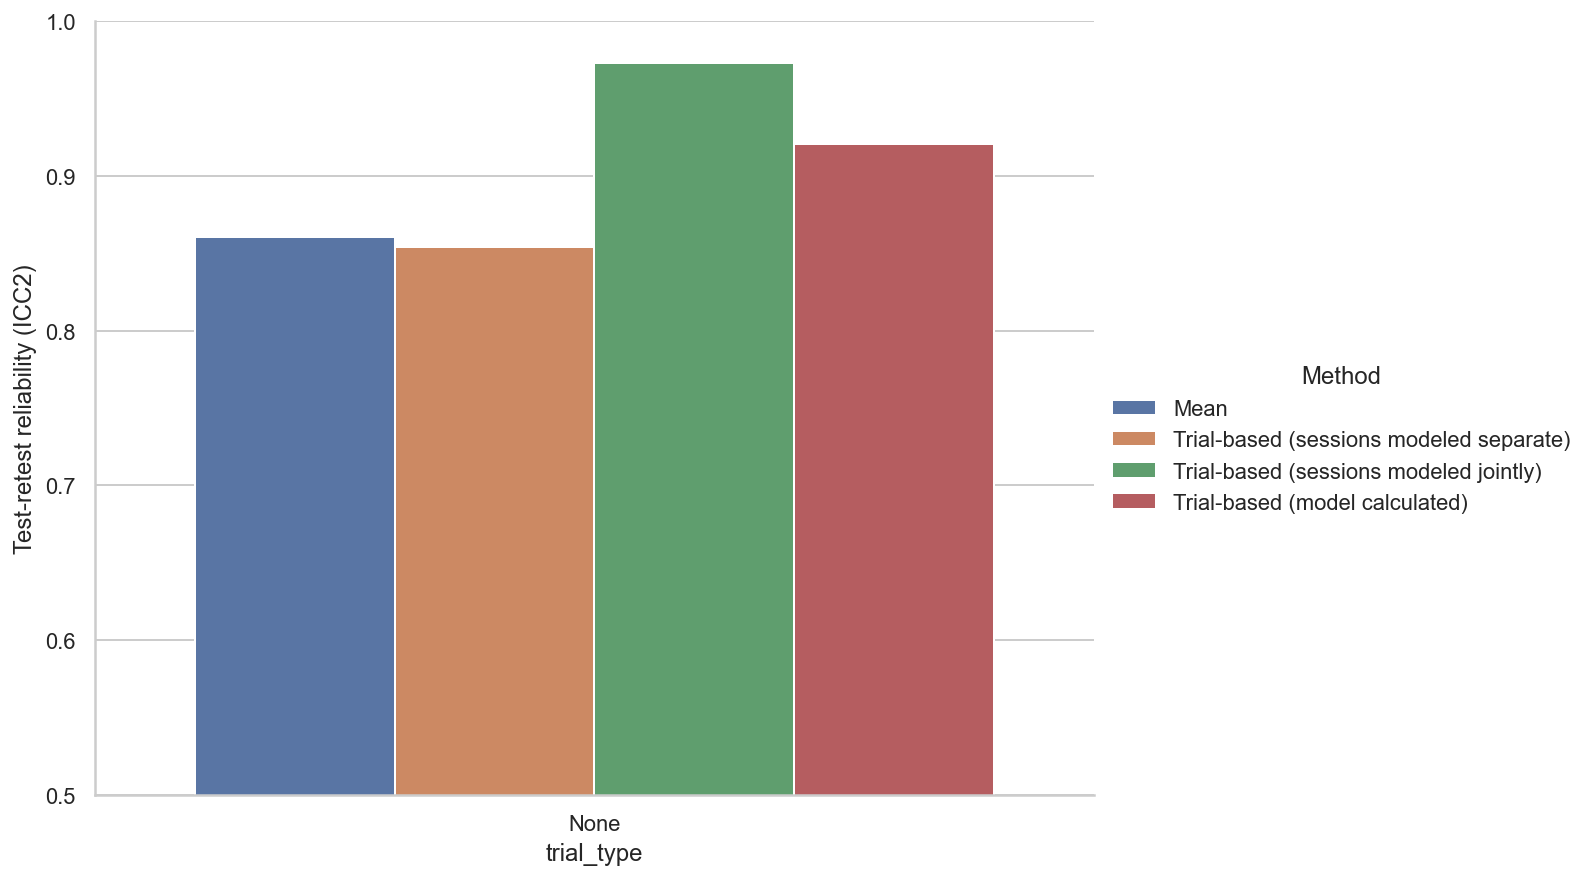

In [ ]:
df = pd.DataFrame({})
icc = "ICC2"#'ICC1k'
df.loc['mean','sb'] =                 iccs_mean['iccs'][0].query('type=="%s"'%icc)['ICC'].iloc[0]
df.loc['trial_sep','sb'] =       iccs_trial_sep['iccs'][0].query('type=="%s"'%icc)['ICC'].iloc[0]
df.loc['trial_joint','sb'] =   iccs_trial_joint['iccs'][0].query('type=="%s"'%icc)['ICC'].iloc[0]
df.loc['model_calc','sb'] =   model_calculated_iccs['oversampling_trial_joint']['icc']

df = df.reset_index()
df.rename(columns = {'index':'category','sb':"Test-retest reliability (%s)"%icc}, inplace = True)
df['trial_type'] = "None"#df.category.apply(lambda x: x.split('_')[-1])
df['Method'] = df.category.apply(lambda x: '_'.join(x.split('_')[:]))
df.Method.replace({'mean':'Mean',
                  'trial_sep':'Trial-based (sessions modeled separate)',
                  'trial_joint':'Trial-based (sessions modeled jointly)',
                  'model_calc':'Trial-based (model calculated)'
                  }, inplace = True)

g = sns.catplot(x = "trial_type",       # x variable name
            y = "Test-retest reliability (%s)"%icc,       # y variable name
            hue = "Method",  # group variable name
            data = df,     # dataframe to plot
            kind = "bar",
           ci = None,
            height=6, aspect=1.3)
g.set(ylim=(.5, 1))
ax = g.axes[0][0]
#ax.axhline(.8, color = 'black')

Questions:
- Is the joint model method mathematically similar to ICC(k)s?
  - Perhaps not, this method even improves upon ICC(k)s.
- Is the joint method reducing measurement error or predictable temporal variation?
- Make variance component plots

ToDo:
- Implement Vanessa Brown's Method (This should slightly reduce ICC's)
  - Add this as extra bar in the plot
- Explain Stein's paradox:
  - Usually, the average of past events is the best estimator of future events.
  - According to Stein's paradox, shrinking individual averages (e.g. session averages) towards grand averages (e.g., participant/sample averages) actually improves the prediction based on individual averages.
- Show how the different variances components of the ICCs change between the different methods
- Run unified model with all trial types
  - Perhaps as extra nesting 
- Add error-bars

# Variance components

In [ ]:
def var_comp_plot(title, results):
    perc_variance = []
    for r in results.items():
        perc_variance.append(r[1]['iccs'][1].set_index('type').T[['Participant','Session','Residual']].loc['Percent'])
    df = pd.DataFrame(perc_variance)
    df.index = results.keys()
    ax = df.plot(kind = 'bar', stacked = True)
    ax.grid(False)
    sns.despine()
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.12, 1.05))
    plt.xticks(rotation=0)

## Oversampling

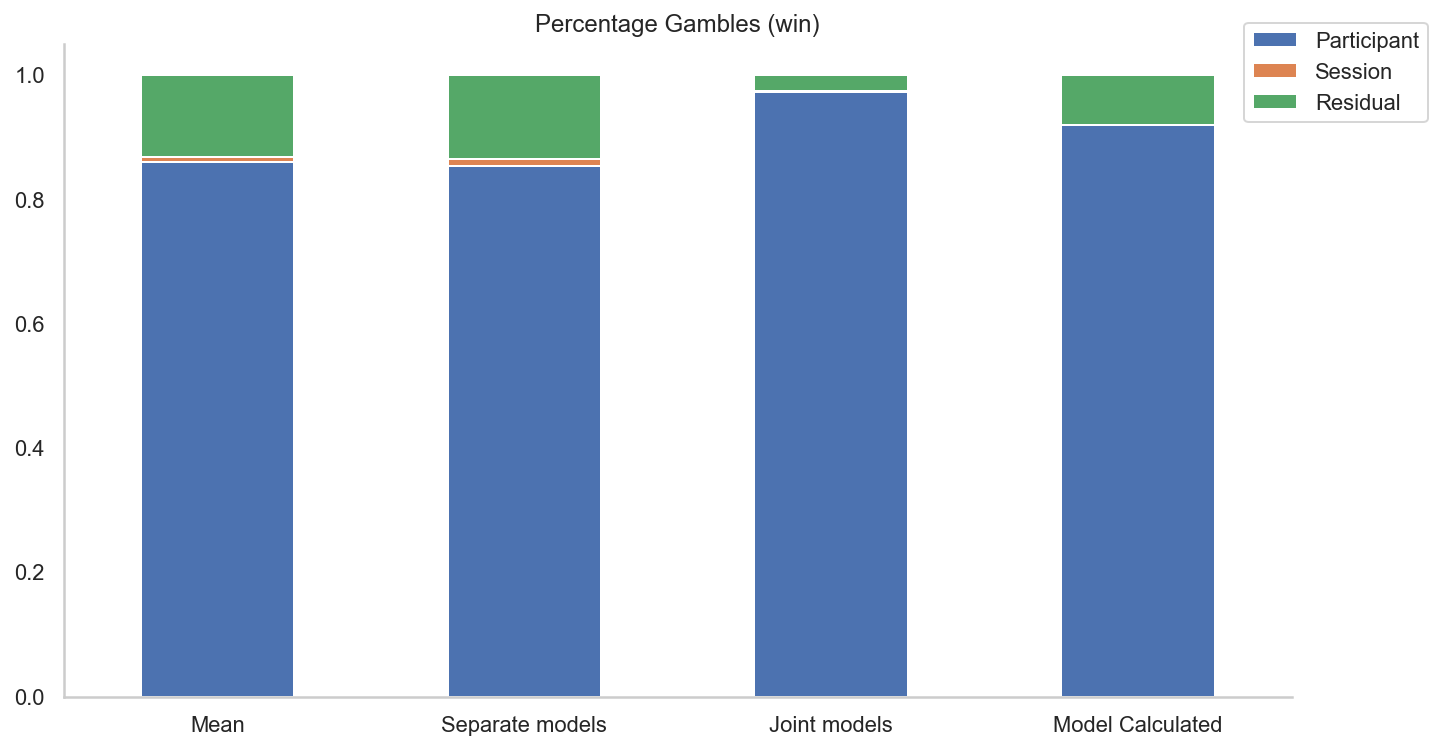

In [ ]:
var_comp_plot("Percentage Gambles (win)",{'Mean':iccs_mean,'Separate models':iccs_trial_sep,'Joint models':iccs_trial_joint,'Model Calculated':model_calculated_iccs['oversampling_trial_joint']['variances']})

Orange bar should be systematic session variance (double check).

# Explorations

## Model different trial types in same model